<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/egb/ModelUnderstanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Recognition Model Understanding

This notebook contains an attempt at understanding what Handwriting Recognition
Models are really learning. Below is an implementation of "Integrated Gradients"
as proposed in the paper,
[Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf).

## Setup

Before we get into the Model Understanding portion, we need to define
the model and be able to load our dataset.

Import the necessary dependencies

In [1]:
# TensorFlow
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.constraints as kc

# Data Structures
import pandas as pd
import numpy as np

# Python
import os

# Image/Plotting
from matplotlib import pyplot as plt

Download the dataset and pre-trained model weights

In [9]:
# IAM Dataset
# ID = 1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9
# FILENAME = iam-line-datasetk.zip
# !wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9" -O iam-line-dataset.zip && rm -rf /tmp/cookies.txt
# !unzip -q iam-line-dataset.zip -d iam
# !rm iam-line-dataset.zip

# IAM Pretrained Model Weights
# ID = 1byCRcIgQz83WhLfRSb8AgEe_u9rIXvWD
# !wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1byCRcIgQz83WhLfRSb8AgEe_u9rIXvWD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1byCRcIgQz83WhLfRSb8AgEe_u9rIXvWD" -O iam_hwr_model_model_understanding.zip && rm -rf /tmp/cookies.txt
# !unzip -q iam_hwr_model_model_understanding.zip
# !rm iam_hwr_model_model_understanding.zip

# French Dataset
# ID = 12nbwG-BLtXVrS2obsIuPs67keku6O_zf
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12nbwG-BLtXVrS2obsIuPs67keku6O_zf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12nbwG-BLtXVrS2obsIuPs67keku6O_zf" -O french_hwr.zip && rm -rf /tmp/cookies.txt
!unzip -q french_hwr.zip
!rm french_hwr.zip

# French Pretrained Model Weights
# ID = 119z2b5u1bq7qXvo6Fbe0YaWhbjc1Rh6u
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=119z2b5u1bq7qXvo6Fbe0YaWhbjc1Rh6u' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=119z2b5u1bq7qXvo6Fbe0YaWhbjc1Rh6u" -O french_model.zip && rm -rf /tmp/cookies.txt
!unzip -q french_model.zip
!rm french_model.zip

replace french_model/run1.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Define some code here to load the dataset into a `tf.data.Dataset`.

In [22]:
# The default list of characters used in the recognition model
DEFAULT_CHARS = ' !"#$%&\'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~£§¨«¬\xad' \
                '°²´·º»¼½¾ÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿłŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ‒–—†‡‰‹›₂₤℔⅓⅔⅕⅖⅗⅘⅙⅚⅛∆∇∫≠□♀♂✓ｆ'

# Turns string of characters into list of characters with indices starting at 1
# We need to retain 0 for the CTC-blank character.
def str_charset_to_lists(charset):
    chars = list(charset)
    indices = list(range(1, len(chars) + 1))
    return chars, indices

# The lookup table to map between characters and integers
def get_char2idx(charset):
    chars, indices = str_charset_to_lists(charset)

    char2idx = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(chars, dtype=tf.string),
            values=tf.constant(indices, dtype=tf.int64)
        ),
        default_value=0,
        name='char2idx_lookup'
    )

    return char2idx

# The lookup table to map between integers and characters
def get_idx2char(charset):
    chars, indices = str_charset_to_lists(charset)

    idx2char = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(indices, dtype=tf.int64),
            values=tf.constant(chars, dtype=tf.string)
        ),
        default_value='',
        name='idx2char_lookup'
    )

    return idx2char

# This is a clever way of padding of truncating sequences with using a loop.
# To run on graph mode, we need to use entirely tf.* functions.
def pad_or_truncate(t, sequence_size=128):
    dim = tf.size(t)
    return tf.cond(tf.equal(dim, sequence_size), lambda: t,
                   lambda: tf.cond(tf.greater(dim, sequence_size), lambda: tf.slice(t, [0], [sequence_size]),
                                   lambda: tf.concat([t, tf.zeros(sequence_size - dim, dtype=tf.int64)], 0)))


# This is a clever way of merging repeating values without using a loop.
# To run on graph mode, we need to use entirely tf.* functions.
def merge_repeating_values(t):
    t2 = tf.roll(tf.pad(t, [[0, 1]], constant_values=-1), -1, 0)[:tf.size(t)]
    not_equal = tf.math.not_equal(t, t2)
    indices = tf.where(not_equal)
    return tf.reshape(tf.gather(t, indices), [-1])

# Convert a string to its integer tensor representation
def str_to_idxs(string, char2idx, sequence_size):
    idxs = tf.map_fn(lambda char: char2idx.lookup(char), tf.strings.unicode_split(string, 'UTF-8'), dtype=tf.int64)
    return pad_or_truncate(idxs, sequence_size=sequence_size)

# Convert an integer tensor to its character representation
def idxs_to_str(idxs, idx2char, merge_repeated=True):
    if merge_repeated:
        idxs = merge_repeating_values(idxs)

    string = tf.map_fn(lambda idx: idx2char.lookup(idx), idxs, dtype=tf.string)
    string = tf.strings.reduce_join(string)
    return tf.strings.strip(string)

# Convert a batch of strings to its given integer tensor representation
def str_to_idxs_batch(batch, char2idx, sequence_size=128):
    return tf.map_fn(lambda string: str_to_idxs(string, char2idx, sequence_size=sequence_size), batch,
                     dtype=tf.int64)

# Convert a batch of integer tensors to its given string representation 
def idxs_to_str_batch(batch, idx2char, merge_repeated=True):
    return tf.map_fn(lambda idxs: idxs_to_str(idxs, idx2char, merge_repeated=merge_repeated), batch,
                     dtype=tf.string)
    
def img_resize_with_pad(img_tensor, desired_height, desired_width):
    img_size = tf.shape(img_tensor)

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_height / desired_width

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = desired_height
      new_width = int(desired_height // img_ratio)
    else:
      new_height = int(desired_width * img_ratio)
      new_width = desired_width
      # Solve by width
    
    resized_img = tf.image.resize(img_tensor, (new_height, new_width), method=tf.image.ResizeMethod.BICUBIC)

    pad_height = desired_height - new_height
    pad_width = desired_width - new_width

    img_padded = tf.pad(resized_img, [[pad_height, 0], [0, pad_width], [0, 0]], constant_values=255)

    return img_padded

def read_and_encode_image(img_path, img_size=(64, 1024)):
    img_bytes = tf.io.read_file(img_path)
    img = tf.image.decode_image(img_bytes, expand_animations=False)
    img = img_resize_with_pad(img, img_size[0], img_size[1])
    img = tf.image.per_image_standardization(img)

    return img

def encode_img_and_transcription(img_path, transcription, char2idx, sequence_size=128, img_size: tuple = (64, 1024)):
    img = read_and_encode_image(img_path, img_size)
    line = str_to_idxs(transcription, char2idx, sequence_size)
    return img, line

def get_encoded_dataset_from_csv(csv_path, char2idx, max_seq_size, img_size):
    path_sep = os.path.sep
    path_prefix = tf.strings.join(csv_path.split('/')[:-1], path_sep)
    return tf.data.experimental.CsvDataset(csv_path, ['img', 'trans'], field_delim='\t', use_quote_delim=False).map(
        lambda img_path, transcription: encode_img_and_transcription(
            tf.strings.join([path_prefix, tf.strings.reduce_join(tf.strings.split(img_path, '/'), separator=path_sep)],
                            separator=path_sep),
            transcription, char2idx, max_seq_size, img_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

def get_dataset_size(csv_path):
    return len(pd.read_csv(csv_path, sep='\t', header=None, names=['img_path', 'transcription']))

Define the Model

In [11]:
class FullGatedConv2D(kl.Conv2D):
    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        output = super(FullGatedConv2D, self).call(inputs)
        linear = kl.Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = kl.Activation("sigmoid")(output[:, :, :, self.nb_filters:])
        return kl.Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

class Recognizer(tf.keras.Model):
    def __init__(self, vocabulary_size=197, input_shape=(1, 1024, 64, 1)):
        super(Recognizer, self).__init__(name='flor_recognizer')

        self.permute = kl.Permute([2, 1, 3])
        self.conv1 = tf.keras.Sequential(name='conv1')
        self.conv1.add(
            kl.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer="he_uniform", batch_input_shape=input_shape))
        self.conv1.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv1.add(kl.BatchNormalization(renorm=True))
        self.conv1.add(FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same"))

        self.conv2 = tf.keras.Sequential(name='conv2')
        self.conv2.add(
            kl.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv2.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv2.add(kl.BatchNormalization(renorm=True))
        self.conv2.add(FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same"))

        self.conv3 = tf.keras.Sequential(name='conv3')
        self.conv3.add(
            kl.Conv2D(filters=40, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv3.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv3.add(kl.BatchNormalization(renorm=True))
        self.conv3.add(
            FullGatedConv2D(filters=40, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout1 = kl.Dropout(rate=0.2, name='dropout1')

        self.conv4 = tf.keras.Sequential(name='conv4')
        self.conv4.add(
            kl.Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv4.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv4.add(kl.BatchNormalization(renorm=True))
        self.conv4.add(
            FullGatedConv2D(filters=48, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout2 = kl.Dropout(rate=0.2, name='dropout2')

        self.conv5 = tf.keras.Sequential(name='conv5')
        self.conv5.add(
            kl.Conv2D(filters=56, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv5.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv5.add(kl.BatchNormalization(renorm=True))
        self.conv5.add(
            FullGatedConv2D(filters=56, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout3 = kl.Dropout(rate=0.2, name='dropout3')

        self.conv6 = tf.keras.Sequential(name='conv6')
        self.conv6.add(
            kl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv6.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv6.add(kl.BatchNormalization(renorm=True))

        self.mp = kl.MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding="valid", name='mp')
        self.reshape = kl.Reshape((128, 64), name='reshape')

        self.gru1 = tf.keras.Sequential(name='gru1')
        self.gru1.add(kl.Bidirectional(kl.GRU(units=128, return_sequences=True, dropout=0.5)))
        self.gru1.add(kl.Dense(units=256))
        self.gru1.add(kl.PReLU())

        self.gru2 = tf.keras.Sequential(name='gru2')
        self.gru2.add(kl.Bidirectional(kl.GRU(units=128, return_sequences=True, dropout=0.5)))
        self.gru2.add(kl.Dense(units=vocabulary_size))

    def call(self, x, training=False, visualize_activations=False, **kwargs):
        x = self.permute(x)

        # CNN
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        out = self.dropout1(out, training=training)
        out = self.conv4(out)

        out = self.dropout2(out, training=training)
        out = self.conv5(out)

        out = self.dropout3(out, training=training)
        out = self.conv6(out)

        # MaxPool and Reshape
        out = self.mp(out)
        out = self.reshape(out)

        # RNN
        out = self.gru1(out)
        out = self.gru2(out)

        return out

## Model Understanding

Once we've defined our model and dataset loading, we can now move to model
understanding. The section implements the integrated gradients approach to
model interpretability.

In [34]:
def make_prediction(image):
    if tf.rank(image) < 4:
        image = tf.expand_dims(image, 0)

    output = model(image)
    prediction = tf.math.top_k(output, k=5).indices
    prediction = tf.cast(prediction, dtype=tf.int64)

    return prediction

def show(image, std=False, title=None, figsize_scale=(40, 40)):
    if tf.rank(image) > 2:
        image = tf.squeeze(image)

    plt.figure(figsize=figsize_scale)
    plt.title(title)
    if std:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(image, cmap='gray')#, vmin=0, vmax=255)
    plt.pause(0.01)

def compute_gradient(image, timestep, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = model(image)
        output = tf.keras.activations.softmax(output, 2)[:, timestep, class_idx]
    return tape.gradient(output, image)

def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

def integrated_gradients(img, timestep, class_idx):
    m_steps = 50
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    baseline_img = tf.fill((64, 1024, 1), value=255.0)

    imgs  = interpolate_images(baseline_img, img, alphas)

    gradients = compute_gradient(imgs, timestep, class_idx)
    
    avg_gradients = integral_approximation(gradients)

    integrated_gradients = (img - baseline_img) * avg_gradients

    return integrated_gradients

def prediction_confidence(output):
    batch_size = output.shape[0]
    seq_size = output.shape[1]

    values = merge_repeating_values(tf.squeeze(tf.argmax(output, 2), 0))
    mask = tf.not_equal(values, tf.constant(0, dtype=tf.int64))
    unpadded_label = tf.boolean_mask(values, mask)
    label = tf.expand_dims(pad_or_truncate(unpadded_label, sequence_size=seq_size), 0)

    input_lengths = tf.constant(np.full(batch_size, seq_size))
    label_lengths = tf.math.count_nonzero(label, axis=1)

    loss = tf.nn.ctc_loss(label, output, label_lengths, input_lengths, logits_time_major=False)

    probability = tf.exp(-loss)[0].numpy()

    return probability

def word_slices(prediction, space_index=1, pixel_to_timestep_ratio=8, buffer=3):
    max_length = tf.size(prediction).numpy() * pixel_to_timestep_ratio
    space_indices = tf.squeeze(tf.where(prediction == space_index)).numpy()

    prev_index = 0

    segments = []
    for index in space_indices:
        if index - prev_index > 1:
            word_slice = prediction[prev_index:index]
            non_blank_indices = tf.where(word_slice != 0)

            minimum = prev_index + tf.reduce_min(non_blank_indices).numpy()
            maximum = prev_index + tf.reduce_max(non_blank_indices).numpy()

            start = minimum * pixel_to_timestep_ratio
            end = (maximum + buffer) * pixel_to_timestep_ratio
            segments.append([start, end])

        prev_index = index
    
    # Get last word
    if tf.size(prediction).numpy() != prev_index + 1:
        word_slice = prediction[prev_index:tf.size(prediction).numpy()]
        non_blank_indices = tf.where(word_slice != 0)
        minimum = prev_index + tf.reduce_min(non_blank_indices)
        maximum = prev_index + tf.reduce_max(non_blank_indices)

        start = minimum.numpy() * pixel_to_timestep_ratio
        end = (maximum.numpy() + buffer) * pixel_to_timestep_ratio
        end = end if end <= max_length else max_length
        segments.append([start, end])
    
    return segments

def segment_img(img, start, end):
    return img[:, start:end, :]

In [17]:
!ls french_hwr

images	labels.csv  labels_unshuffled.csv


In [64]:
dataset_csv_path = './french_hwr/labels.csv'
model_weights_path = './french_model/run1'

char2idx = get_char2idx(DEFAULT_CHARS)
idx2char = get_idx2char(DEFAULT_CHARS)
max_seq_size = 128
img_size = (64, 1024)

dataset_size = get_dataset_size(dataset_csv_path)
train_dataset_size = int(.8 * dataset_size)
val_dataset_size = dataset_size - train_dataset_size

dataset = get_encoded_dataset_from_csv(dataset_csv_path, char2idx, max_seq_size, img_size)
train_dataset = dataset.take(train_dataset_size).as_numpy_iterator()
val_dataset = dataset.skip(train_dataset_size).as_numpy_iterator()

model = Recognizer()
model.load_weights(model_weights_path)

Run one of the next two codeblocks to grab an image from the dataset to use
for evaluation.

Select an image from the training set. If you'd like to select a different
image, simply run the codeblock again.

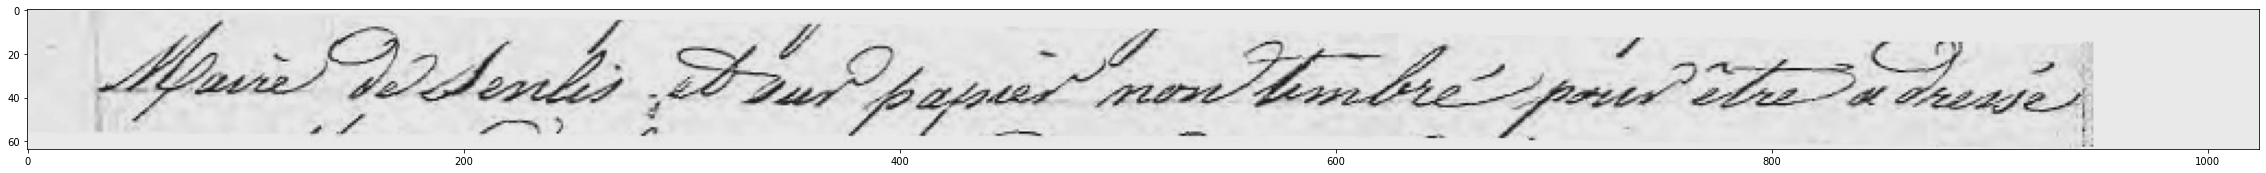

In [90]:
img, label = next(train_dataset)
show(img)

Select an image from the validation set. If you'd like to select a different
image, simply run the codeblock again.

In [ ]:
img, label = next(val_dataset) # The first run will take a second as it skips over the training set
show(img)

### Image Distortions

Observe the prediction from model when we send in the original image.

In [46]:
output = model(tf.expand_dims(img, 0))
pred = tf.squeeze(tf.argmax(output, 2))
str_pred = idxs_to_str(pred, idx2char).numpy().decode('utf8')
print('Output:', pred)
print('Prediction:', str_pred)
print('Confidence: {:.4f}'.format(prediction_confidence(output)))

Output: tf.Tensor(
[  0   0   0   0  65  74  74   0   1   1   0  61   1   1 122   0  80 122
   0   1   0  66   0  61  69  80   0  65   0   1  65  65  80   1  74   0
   0  75  74   0   0   1  46   0   0  68   0  69  72  69  69  62   0  65
  78   0  80   0   1   1  31   0  81   0  67  67  78  69  69  79   1   1
  72   8  61   0  74   0  80  78  78  65   1  64  64   0 122  63  72  61
   0  78   0  61  74  74  80   0   1   1  76   0   0  75   0  81   0  78
   1   1  74   0  65   0   1   1  79   0  61   0  82   0  75  69   0  80
   0   0], shape=(128,), dtype=int64)
Prediction: en a été faite et non Philibert Augris l'antre déclarant pour ne savoit
Confidence: 0.0198


Modify the original image in some way and see how it affects the model's final
classification.

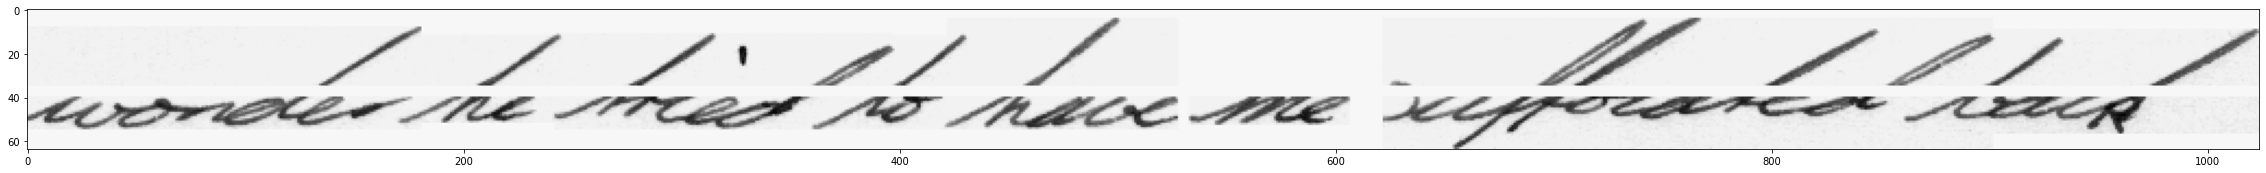

Output: tf.Tensor(
[ 0  0 83  0  0  0 75  0  0 78  0  0 75  0  0  0 72  0  0 78  0  0  1  1
 80 68  0 65 65  0  1  1  1  0  0 68  0 65  0 69  0  0 79  0  0  1 72  0
  0  0 75  0  0  1  1 43  0  0  0 61  0  0 82  0 65  0  0 14  0 73  0  0
  0  0 65  0  1  1 79 79  0  0  0  0 76  0  0 80  0 68  0  0  0 75  0  0
 75 78  0  0 80  0  0 61  0  0  1  1  1 33  0  0  0 68  0 65  0 75  0 76
  0  0  0  0  0  0  0  0], shape=(128,), dtype=int64)
Prediction: worolr the heis lo Mave-me spthoorta Cheop
Confidence: 0.0000


In [ ]:
img_copy = img.copy()
img_copy[35:40, :, :] = 255
show(img_copy)

output = model(tf.expand_dims(img_copy, 0))
pred = tf.squeeze(tf.argmax(output, 2))
str_pred = idxs_to_str(pred, idx2char).numpy().decode('utf8')
print('Output:', pred)
print('Prediction:', str_pred)
print('Confidence: {:.4f}'.format(prediction_confidence(output)))

### The Integrated Gradient

Experiment with the given image by changing the `timestep` and `class_idx`
variables.

The `timestep` variable corresponds with the position in the
sequence. The `class_idx` variable controls the focus character. The image will
then display the influence that each pixel had for predicting the focus
character at that timestep (The focus character is not necessarily the highest
probable character).

The top 5 predictions are given below along with their associated index.

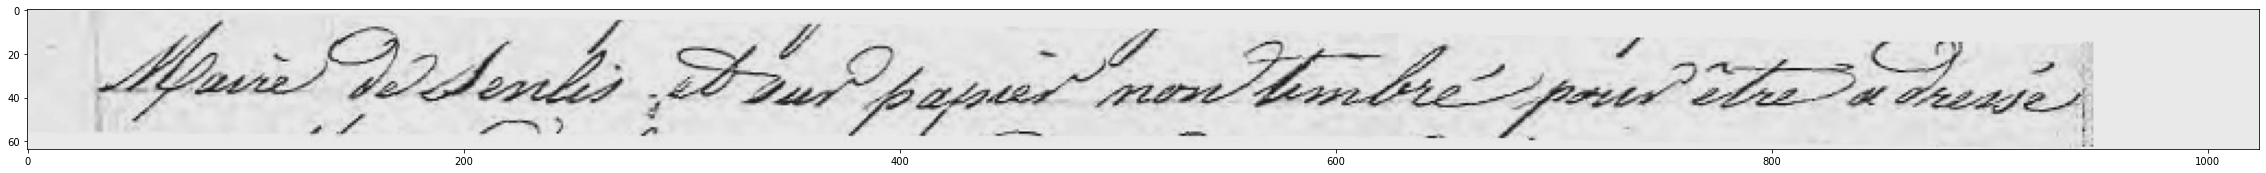

Timestep: 55
Class Index: 79
Full Indices: [  0   0   0   0   0   0  43   0   0   0  61  69  69  78  65  65   0   1
   1  64   0  65   1   1  79   0  65   0  74   0  72   0  69  79   0   0
   1  65   0  80   1   1  79   0  81   0  78   1   1  76   0   0  61  76
   0  79  69  65  78   0   0   1   1  74   0  75   0  74   0   1   0  80
  65  65  73  73   0  62  62   0  78   0 122   0   0   1   1  76   0  75
  81  81  78  78   1   1  65   0  80  78  78  65   0   1   1  61   1   1
  64  78  78  65  79   0  79  65   0   0   0   0   0   0   0   0   0   0
   0   0]
Full Predictions: Maire de senlis et sur papsier non tembré pour etre a dresse
Pred Indices: [79 78 76  0 74]
Top Predictions: [b's' b'r' b'p' b'' b'n']


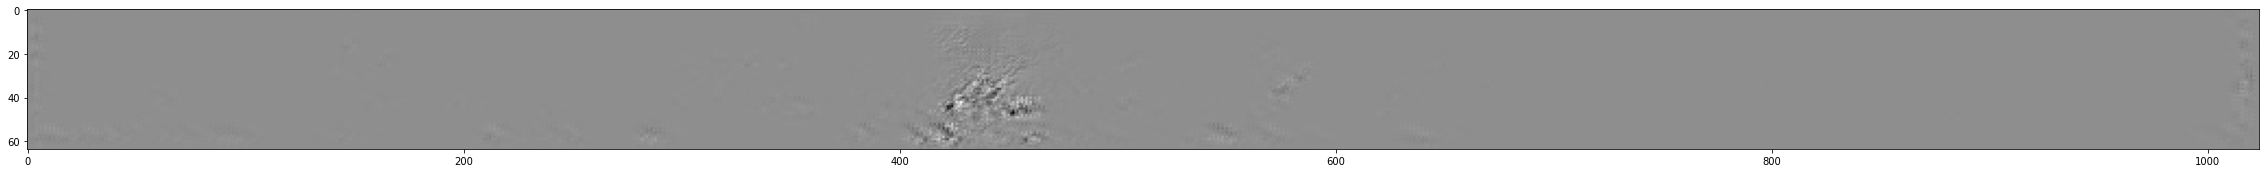

In [97]:
timestep = 55
class_idx = 79

show(img)
pred = make_prediction(img)

print('Timestep:', timestep)
print('Class Index:', class_idx)
print('Full Indices:', pred.numpy()[0, :, 0])
print('Full Predictions:', idxs_to_str(pred[0, :, 0], idx2char, merge_repeated=True).numpy().decode('utf8'))
print('Pred Indices:', pred.numpy()[0][timestep])
print('Top Predictions:', idx2char.lookup(pred[0][timestep]).numpy())
gradients = integrated_gradients(img, timestep, class_idx)
show(gradients, std=False)

### Observe the Gradient Per Timestep

Notice where gradients in each timestep correspond to the pixels in the image.
This is due to CTC-loss training that provides an implicit segmentation of
the line image. Due to the model training, you can see this segmentation occur
even with a blank white image.

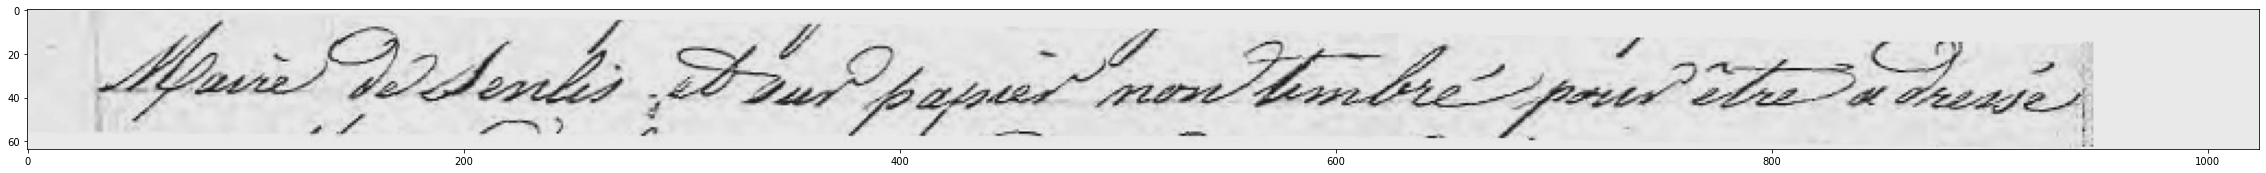

In [102]:
show(img)

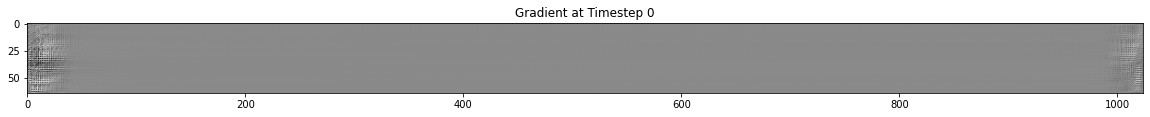

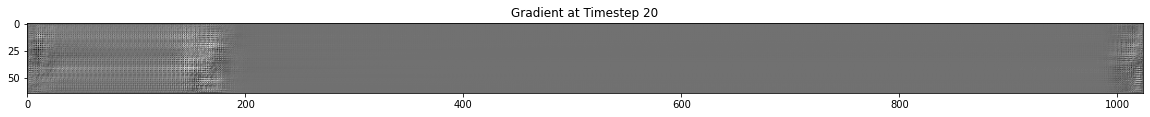

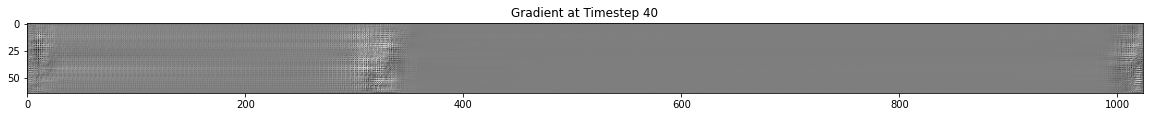

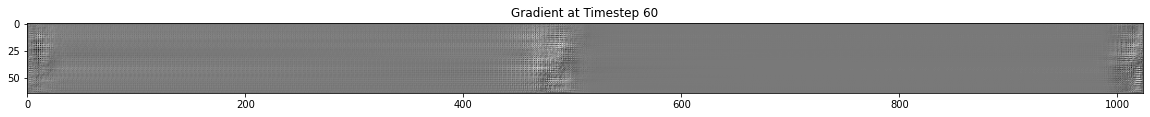

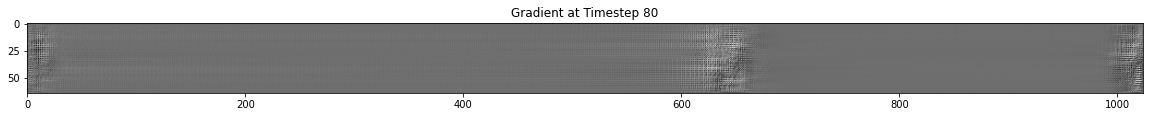

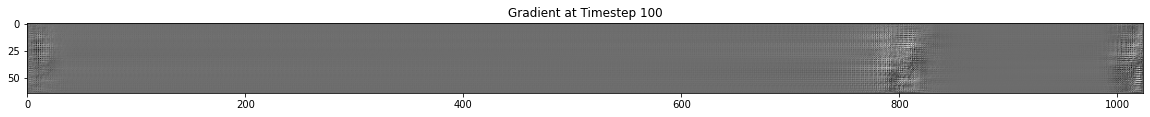

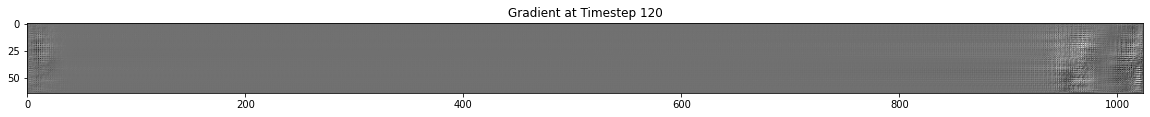

In [103]:
white_img = tf.fill((1, 64, 1024, 1), .4)
step_size = 20

for timestep in range(0, 128, step_size):
    gradient = compute_gradient(white_img, timestep, 0)
    show(gradient, title='Gradient at Timestep ' + str(timestep), figsize_scale=(20,20))

### Perform Word-Level Segmentation Based on Output from Model

In [84]:
b'\xc3\xa0'.decode('utf8')

'à'

Prediction: Maire de senlis et sur papsier non tembré pour etre a dresse


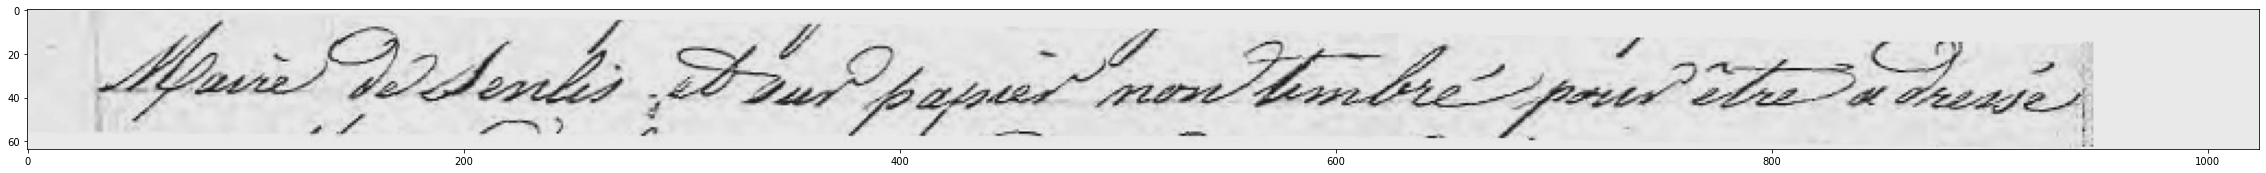

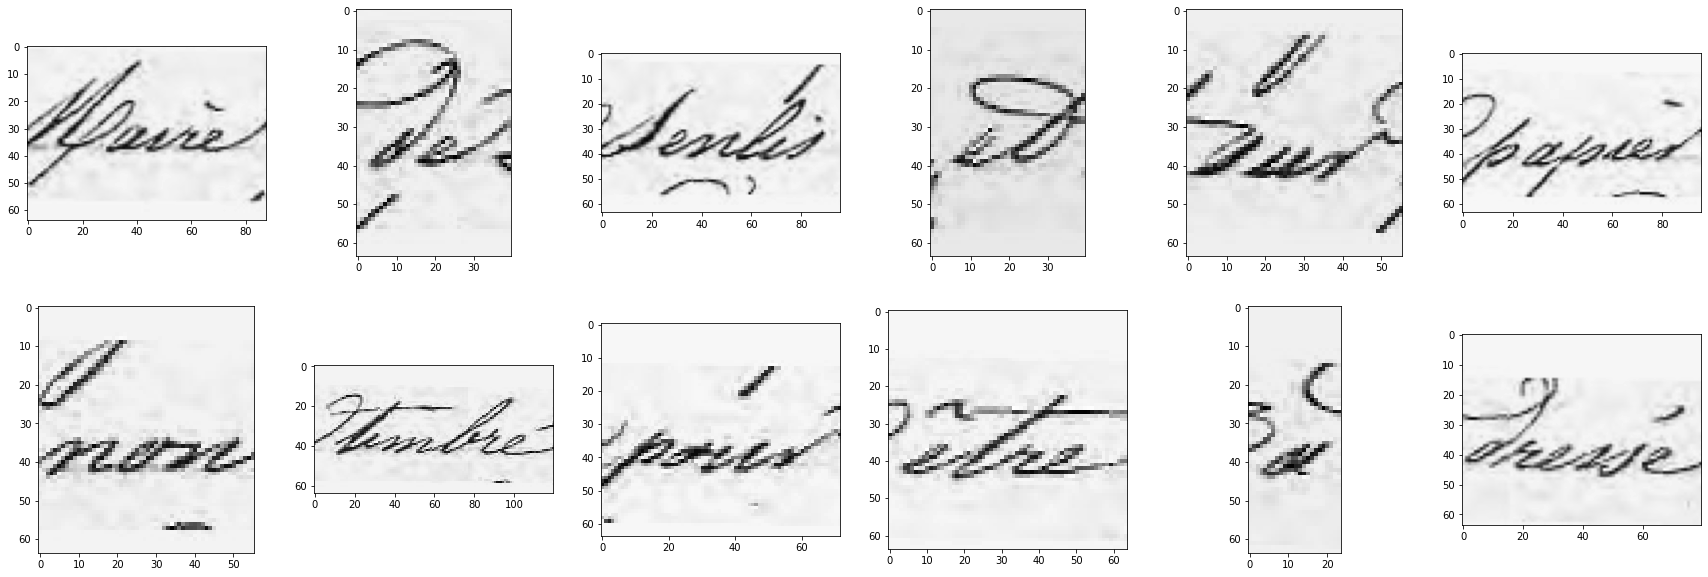

In [91]:
IMGS_PER_ROW = 6

output = model(tf.expand_dims(img, 0))
pred = tf.squeeze(tf.argmax(output, 2))
print('Prediction:', idxs_to_str(pred, idx2char).numpy().decode('utf8'))

segmentation_coordinates = word_slices(pred, buffer=2)

show(img)
f, axarr = plt.subplots(nrows=int(np.ceil(len(segmentation_coordinates) / IMGS_PER_ROW)), ncols=IMGS_PER_ROW, figsize=(30, 10))
for index, (start, end) in enumerate(segmentation_coordinates):
    row = index // IMGS_PER_ROW
    col = index % IMGS_PER_ROW

    word_img = segment_img(img, start, end)
    axarr[row, col].imshow(tf.squeeze(word_img), cmap='gray')
    # word_img = segment_img(img, start, end)
    # show(word_img, figsize_scale=(2, 2))